**Goal**: _In this task, you have to design a solution that will help the vendors add new items
to their menu_.

**Solutions:**

1. Based on given data, build a **predictive model** to predict the possible sales/orders. So vendors can use this model to predict their sales/ orders based on the type of product and the description of the product.


**Steps:**
1. Import Libs & Data
2. Data Exploration & Cleaning
3. Feature Engineering


    3.1 How many product one vendor have (A rough measure of vendor size)
    3.2 What's the popularity of one vendor_geohash (# of vendor in one vendor_geohash)
    3.3 Wheather the product have a description or not (boolean)
    3.4 Length of the Product name & Length of the Product description
    3.5 Create new Features based on above NLP anlysis
        * How many popular key words the product name contains
        * How many popular key words the product description contains
    
    
    

4. Build Predictive Models & Validation
5. Future improvements

### 1. Import Libs & Data 

In [48]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Modelling Algorithms
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression, SGDRegressor, Lasso,ElasticNet, Ridge,HuberRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeClassifier

# Modelling Helpers
from sklearn.preprocessing import Normalizer, scale
from sklearn.feature_selection import RFECV, SelectKBest, chi2
from sklearn.preprocessing import scale, MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kuangzheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kuangzheng/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kuangzheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
raw_data = pd.read_parquet('products.gz')

In [3]:
# helper functions to plot
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print(model.score( X , y ))

### 2. Data Exploration & Cleaning

In [4]:
raw_data.head()

,product_id,vendor_id,vendor_geohash,product_name,product_description,order_count
0,0,0,w21zv3v,"Double Boiled Soup, Rice & 3 Dishes",Vegetarian,38
1,1,1,w21ztnr,Goreng Pisang,5 Pcs,26
2,2,2,w21ztje,Chicken Ham Sub,Lean and tender sliced chicken ham with your c...,31
3,3,3,w21zunx,Instant Noodles 快熟面,Per pc,88
4,4,4,w21zety,Mini Yolky Custard Pau,3 Pc,62


In [5]:
raw_data.product_name.value_counts()

Coke                        739
Iced Lemon Tea              498
Sprite                      416
Rice                        334
Mee Goreng                  319
                           ... 
100 Plus | 500 ml             1
D19. Rose Syrup Limau         1
Pu Tien Fried Noodle          1
Rice + Mutton                 1
T08. Thosai Masala & Egg      1
Name: product_name, Length: 105780, dtype: int64

In [6]:
raw_data.product_description.value_counts()

Toppings available                                                          1984
100g                                                                        1604
3 Pcs                                                                       1160
Choices and toppings available                                              1112
2 Pcs                                                                        897
                                                                            ... 
Penne pasta with burrata cheese with garlic in cherry tomato sauce             1
Vegetarian, bread fried in egg served with peanut butter                       1
Served with sweet chili sauce                                                  1
Includes chicken rice, soup & vegetable of the day                             1
Gomiti pasta, pulled smoked duck, sautéed mushroom, baked with 3 cheeses       1
Name: product_description, Length: 33724, dtype: int64

In [7]:
raw_data.vendor_geohash.value_counts()

w21zetv    2921
w21z8dz    2302
w23b1tq    2281
w23bh25    2234
w23b4u5    2084
           ... 
w21ze2p       1
w21zs7p       1
w21zdfe       1
w21z73s       1
w21zduu       1
Name: vendor_geohash, Length: 2068, dtype: int64

In [8]:
raw_data.order_count.describe()

count    300774.000000
mean          9.215780
std          23.479511
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        2017.000000
Name: order_count, dtype: float64

In [9]:
#  Deal with Missing data
print( 'Check if dataframe contains null: ')
print(raw_data.isnull().sum())

# It seems only description has null values and it can be truned into a feature
data = raw_data.copy()
data['has_description'] = ~data.product_description.isnull()
data.fillna("no_description", inplace = True)
print('\nAfter fillna: ')
print(data.isnull().sum())

Check if dataframe contains null: 
product_id                  0
vendor_id                   0
vendor_geohash              0
product_name                0
product_description    184250
order_count                 0
dtype: int64

After fillna: 
product_id             0
vendor_id              0
vendor_geohash         0
product_name           0
product_description    0
order_count            0
has_description        0
dtype: int64


In [10]:
# all non English and invalid items should be cleaned up
def eliminate_non_english_char(s):
    printable = set(string.printable)
    s = ''.join(filter(lambda x: x in printable, s))
    return ''.join(x for x in s if x.isalpha() or x ==' ')

data['processed_product_name'] = data['product_name'].apply(eliminate_non_english_char)
print(data['processed_product_name'])

0         Double Boiled Soup Rice   Dishes
1                            Goreng Pisang
2                          Chicken Ham Sub
3                         Instant Noodles 
4                   Mini Yolky Custard Pau
                        ...               
300769       Green Curry Chicken with Rice
300770                 Nasi Lemak Set B  B
300771                        Lady Fingers
300772                      Briyani Mutton
300773        R Hainanese Chicken Rice Set
Name: processed_product_name, Length: 300774, dtype: object


### 3. Feature Engineering

#### 3.1 How many product one vendor have (A rough measure of vendor size)

In [11]:


product = data.groupby('vendor_id')['product_id'].nunique().reset_index()


product.columns = ['vendor_id','num_of_product']

data = data.merge(product,on='vendor_id', how='left')

#### 3.2 What's the popularity of one vendor_geohash (# of vendor in one vendor_geohash)


In [12]:

number_of_vendor = data.groupby('vendor_geohash')['vendor_id'].nunique().reset_index()

number_of_vendor.columns = ['vendor_geohash','num_of_vendor']

data = data.merge(number_of_vendor,on='vendor_geohash', how='left')

#### 3.3 Wheather the product have a description or not (boolean)

In [13]:

data['has_description'].describe()

count     300774
unique         2
top        False
freq      184250
Name: has_description, dtype: object

#### 3.4 Length of the Product name & Length of the Product description

In [14]:
data['length_of_name'] = data['processed_product_name'].apply(lambda x: len(x))
data['length_of_description'] = data['product_description'].apply(lambda x: len(x))

##### Calculate the 100 most popular key words in product name
##### Calculate the 100 most popular key words in product description

In [15]:


stop = stopwords.words('english') + list(string.punctuation)

def tokenize_product_name(s):
    return [i for i in word_tokenize(s.lower()) if i not in stop]

data['token_product_name'] = data['processed_product_name'].apply(tokenize_product_name)

In [16]:
def tokenize_product_description(s):
    if s != "no_description":
        return [i for i in word_tokenize(s.lower()) if i not in stop]
    else:
        return []
    
data['token_product_description'] = data['product_description'].apply(tokenize_product_description)

In [17]:
data['len_of_token_product_name'] = data['token_product_name'].apply(lambda x: len(x))

In [18]:
data['len_of_token_product_description'] = data['token_product_description'].apply(lambda x: len(x))

In [19]:
name_token_list = [item for sublist in list(data['token_product_name'].values) for item in sublist]

In [20]:
description_token_list = [item for sublist in list(data['token_product_description'].values) for item in sublist]

##### Plot the most frequent words in product name

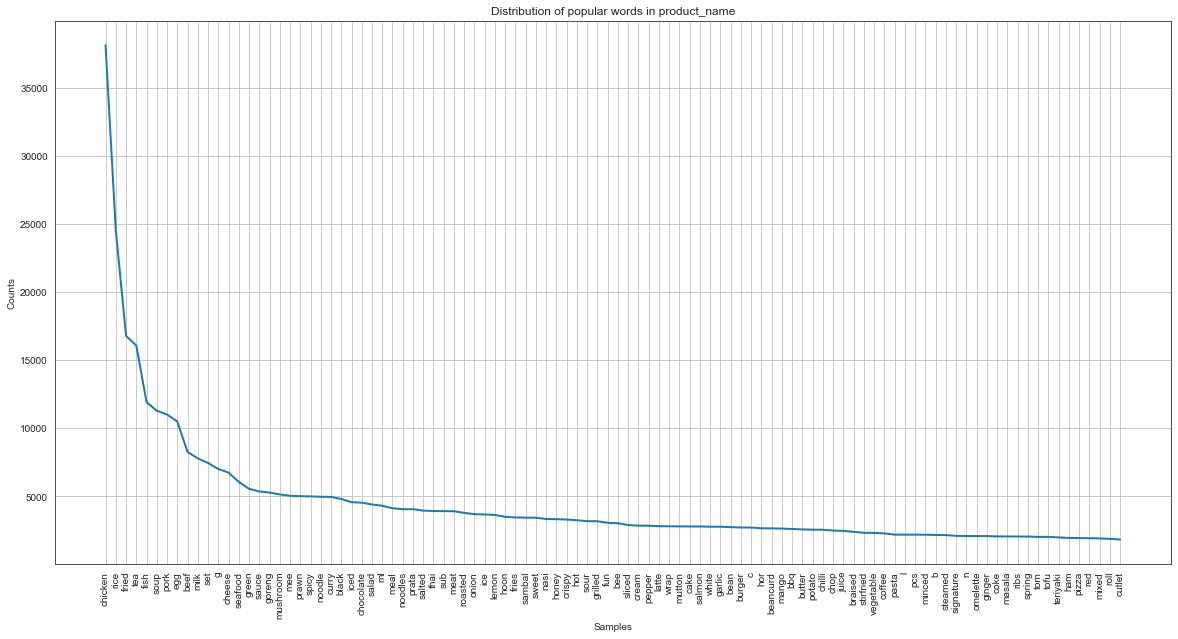

In [49]:
Freq_dist_nltk_name=nltk.FreqDist(name_token_list)
plt.figure(figsize=(20,10))
plt.title('Distribution of popular words in product_name')
Freq_dist_nltk_name.plot(100,cumulative=False)

(-0.5, 399.5, 199.5, -0.5)

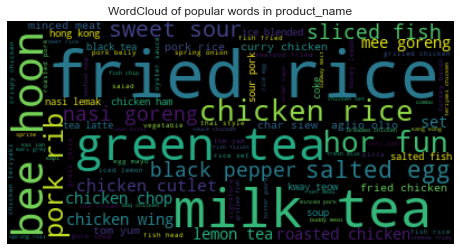

In [51]:
# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(name_token_list))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of popular words in product_name')
plt.axis("off")

##### Plot the most frequent words in product description

In [23]:
Freq_dist_nltk_name_sorted = {k: v for k, v in sorted(Freq_dist_nltk_name.items(), key=lambda item: item[1], reverse=True)}
most_frequent_100_words = list(Freq_dist_nltk_name_sorted.keys())[:100]

    

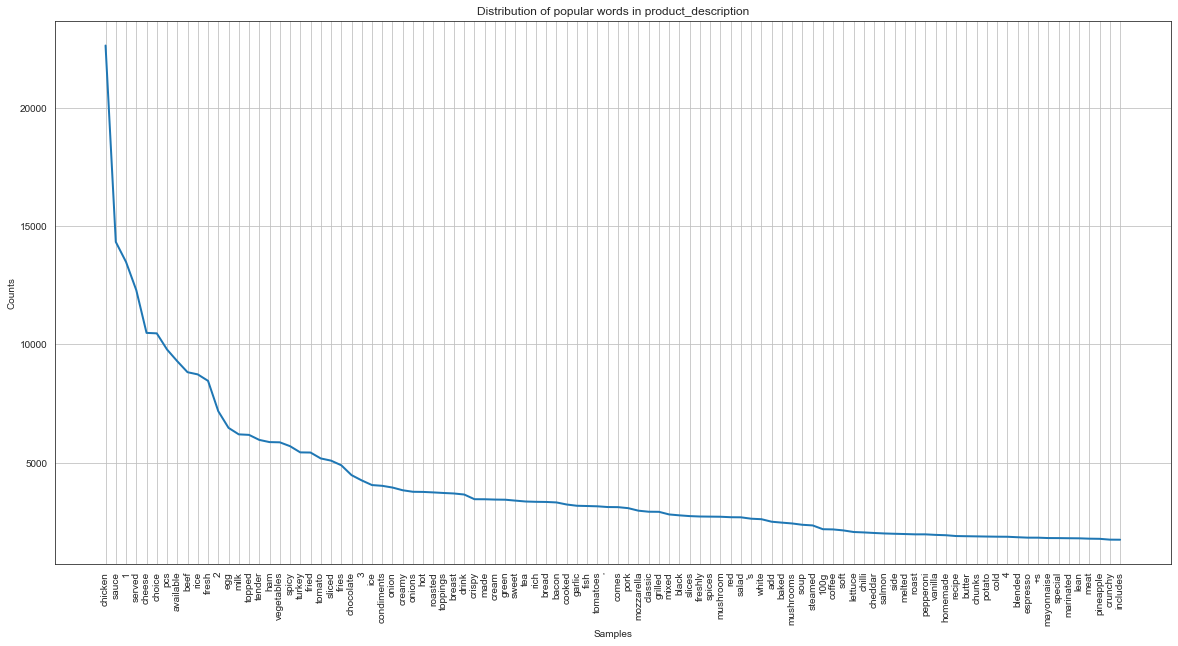

In [53]:
Freq_dist_nltk_description=nltk.FreqDist(description_token_list)
plt.figure(figsize=(20,10))
plt.title('Distribution of popular words in product_description')
Freq_dist_nltk_description.plot(100,cumulative=False)

(-0.5, 399.5, 199.5, -0.5)

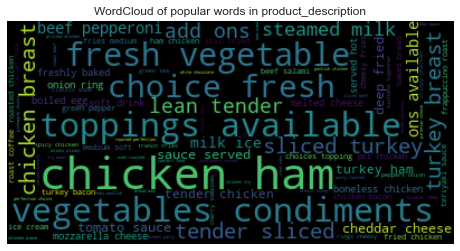

In [52]:
# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(description_token_list))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of popular words in product_description')
plt.axis("off")

In [26]:
Freq_dist_nltk_description_sorted = {k: v for k, v in sorted(Freq_dist_nltk_description.items(), key=lambda item: item[1], reverse=True)}
most_frequent_100_description = list(Freq_dist_nltk_description_sorted.keys())[:100]

#### 3.5 Create new Features based on above NLP anlysis
1. How many popular key words the product name contains
2. How many popular key words the product description contains

In [27]:
data['num_popular_word_name'] = data['token_product_name'].apply(lambda x :len(list(set(x).intersection(most_frequent_100_words))) )

In [28]:
data['num_popular_word_description'] = data['token_product_description'].apply(lambda x :len(list(set(x).intersection(most_frequent_100_description))) )

### Build Predictive Models

In [29]:
list(data)

['product_id',
 'vendor_id',
 'vendor_geohash',
 'product_name',
 'product_description',
 'order_count',
 'has_description',
 'processed_product_name',
 'num_of_product',
 'num_of_vendor',
 'length_of_name',
 'length_of_description',
 'token_product_name',
 'token_product_description',
 'len_of_token_product_name',
 'len_of_token_product_description',
 'num_popular_word_name',
 'num_popular_word_description']

In [33]:
data.to_csv('data.csv')

In [34]:
train_data = data[[ 
    'len_of_token_product_description',
    'len_of_token_product_name',
    'length_of_name',
    'length_of_description',
    'num_popular_word_name',
    'num_popular_word_description',
    'num_of_product',
    'num_of_vendor',
    'has_description',
]]

target_data = data['order_count']

full = data[[ 
    'len_of_token_product_description',
    'len_of_token_product_name',
    'length_of_name',
    'length_of_description',
    'num_popular_word_name',
    'num_popular_word_description',
    'num_of_product',
    'num_of_vendor',
    'has_description',
    'order_count'
]]


In [56]:

# Use Scaler to scale data 

train_valid_X = pd.DataFrame(scale(train_data))

In [58]:
train_valid_X.columns = [ 
    'len_of_token_product_description',
    'len_of_token_product_name',
    'length_of_name',
    'length_of_description',
    'num_popular_word_name',
    'num_popular_word_description',
    'num_of_product',
    'num_of_vendor',
    'has_description',
]

In [71]:
train_valid_X.head()

,len_of_token_product_description,len_of_token_product_name,length_of_name,length_of_description,num_popular_word_name,num_popular_word_description,num_of_product,num_of_vendor,has_description
0,-0.371904,1.308781,1.257153,-0.530339,0.418585,-0.539708,-1.027140,0.975004,1.257465
1,-0.199199,-0.830165,-0.717937,-0.641442,-0.409854,-0.110630,-0.965445,1.201388,1.257465
2,1.009740,-0.117183,-0.510033,1.180642,1.247024,2.892917,0.931696,-0.458764,1.257465
3,-0.199199,-0.830165,-0.406080,-0.619222,-0.409854,-0.539708,-0.055434,-0.760610,1.257465
4,-0.199199,0.595799,0.217632,-0.663663,-1.238293,-0.110630,-0.024586,0.144927,1.257465


In [66]:
train_X , valid_X , train_y , valid_y =train_test_split(train_valid_X,target_data,test_size=0.3)

0.8114096541766211


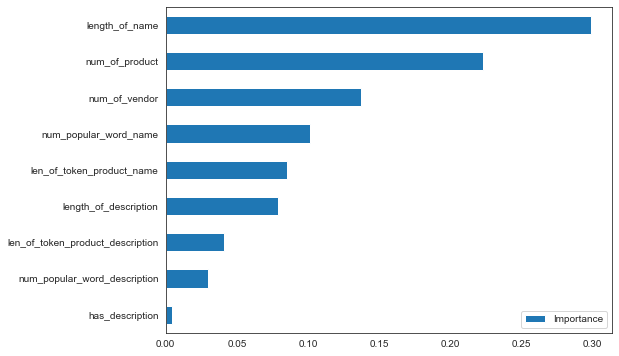

In [67]:
# show the variable importance of different features
plot_variable_importance(train_X, train_y)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


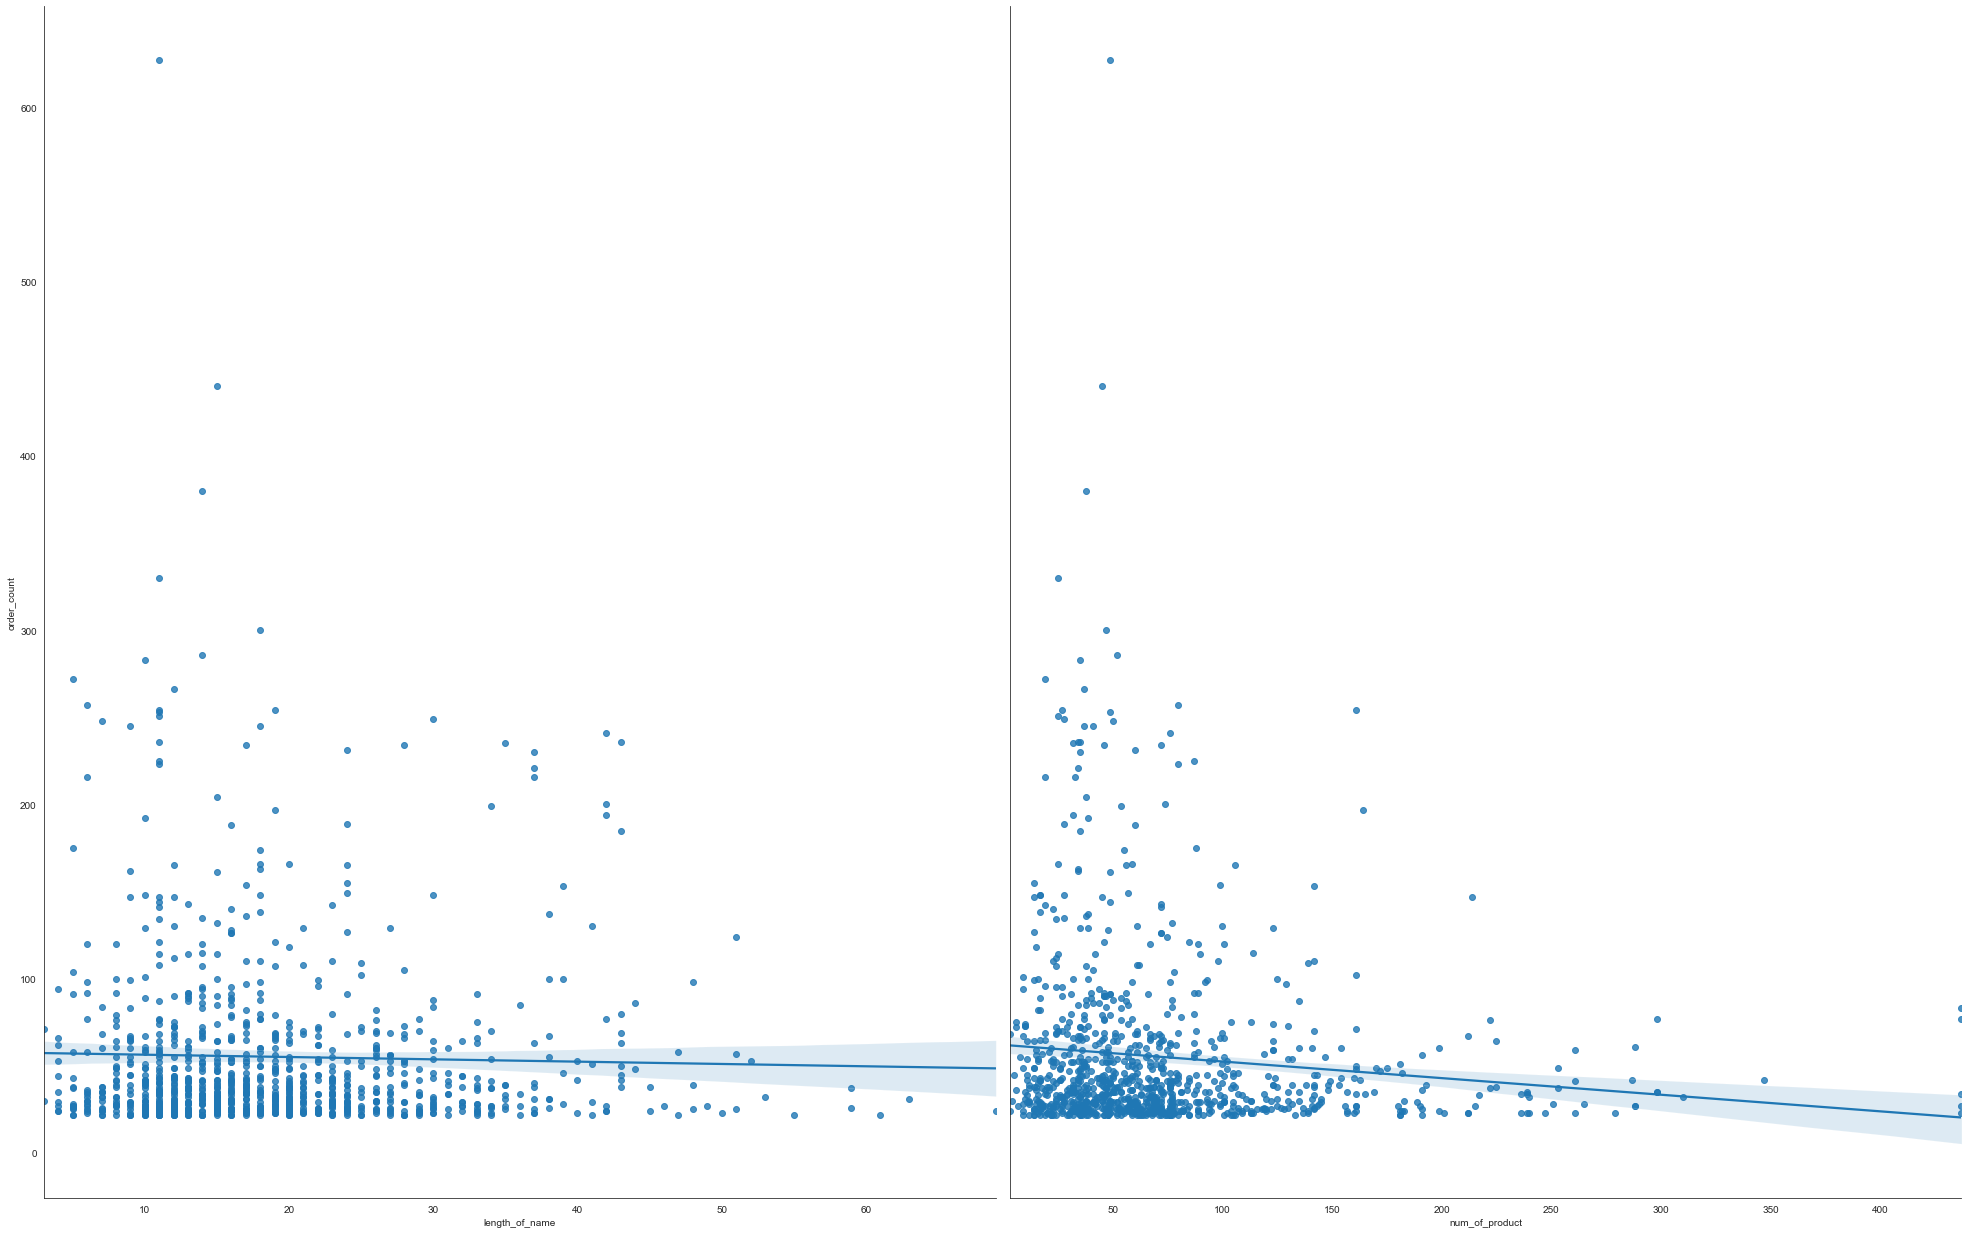

In [46]:
# show the regression trend of different features
sns.pairplot(full[:1000], x_vars=['length_of_name','num_of_product'], y_vars='order_count', size=17, aspect=0.8,kind='reg')

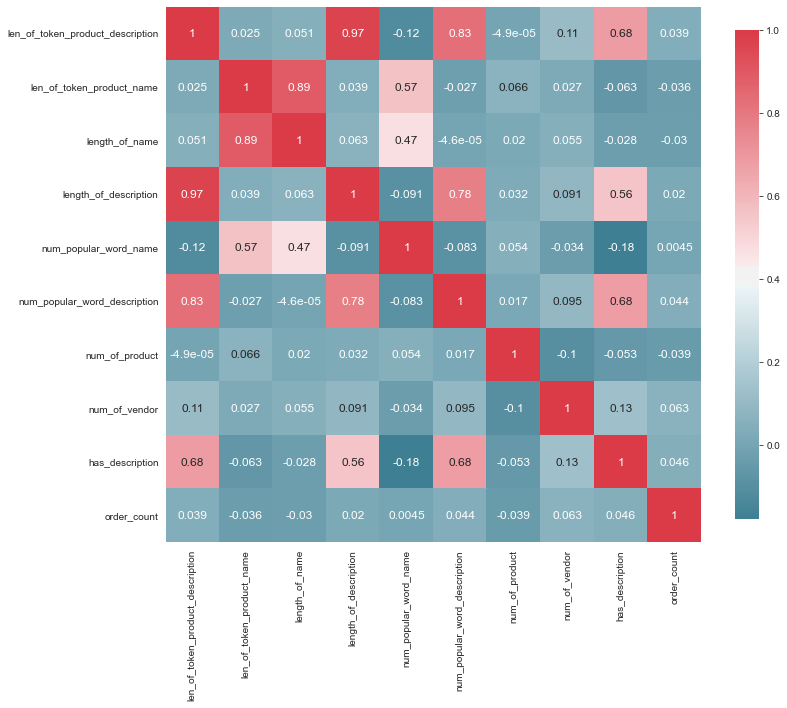

In [35]:
# show the correlation for full dataset
plot_correlation_map( full )

In [68]:
# Constraction of different models

# Linear Regression
def Model_LinearRegression( X , y , vX , vy ):
    model = LinearRegression()
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))


def Model_LinearSVR( X , y , vX , vy):
    model = LinearSVR()
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))


# Ensemble Models

def Model_RandomForestRegressor( X , y , vX , vy):
    model = RandomForestRegressor()
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))

def Model_AdaBoostRegressor( X , y , vX , vy):
    model = AdaBoostRegressor()
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))

def Model_BaggingRegressor( X , y , vX , vy):
    model = AdaBoostRegressor()
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))

# MLP
def Model_MLPRegressor( X , y , vX , vy):
    model = MLPRegressor(hidden_layer_sizes= (20,))
    model.fit( X, y )
    print (model.score( X , y ), model.score( vX, vy ))


In [69]:

# Use different models

# LinearRegression
Linear_result = Model_LinearRegression( train_X , train_y , valid_X , valid_y)

0.014688001074875556 0.01502471293633778


In [38]:
#LinearSVR
Model_LinearSVR( train_X , train_y , valid_X , valid_y)

-0.07759721770982986 -0.07649529563465096


/usr/local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [70]:
# randomforestregressor 
# The result shows the overfitting. I tried to cut the number of estimators but the performance is still not improved.
Model_RandomForestRegressor( train_X , train_y , valid_X , valid_y )

0.8068424936468409 0.22542088246030734


In [45]:
MLP_result = Model_MLPRegressor( train_X , train_y , valid_X , valid_y)

0.03112514660975818 0.025722260408098552


#### Model selection:  Random Forest,  the best score for validation dataset is 0.225

### 5. Future Improvements

1. Put more time and effort to feature engineering & data cleaning.


    1.1 Use geo location data to cluster data and for each cluster we can generate corresponding features. 
        For example:
        most popular product name keywords in certain area.
    1.2 NLP can be applied to measure the similarity of product_name and product_description. This can also be a 
        interesting feature to look at.
    1.3 Tag tokens with NLTK and calculate the distribution of tags for each name and description. 
    1.4 Use domain knowlegde further cluster data. For example, we can cluster product names to several 
        classes and use it as categorical data. Like: Rice, Noodle, Pizza, Soup, Drink, Main Dish....



2. Tuning the model.


    2.1 Cross-validtion
    2.2 Grid-search to tune parameters
    2.3 Try more models and build ensemble models.
    2.4 Try Lighgbm with categorical data to see the performance.
    


In [73]:
!pipreqs .

INFO: Successfully saved requirements file in ./requirements.txt
